In [2]:
import numpy as np

class SSA:
    def __init__(self, L: int, r: int) -> None:
        self.L = L
        self.r = r
    
    def fit(self, ts: np.array):
        self.ts = ts
        self.N = ts.shape[0]
        self.K = self.N - self.L + 1
        
        self.trajectory_matrix = np.column_stack([self.ts[i:i+self.L] for i in range(0, self.K)])
        self.S = self.trajectory_matrix@self.trajectory_matrix.T / self.K
        self.U, self.Sigma, Vtransposed = np.linalg.svd(self.S)
        self.V = Vtransposed.T
        
        self.PC = self.trajectory_matrix.T@self.V
        self.R = self._calculate_R()
        
        self.reconstructed = np.sum(self.R[:, :self.r], axis=1) 
        return self
    
    def predict(self, h: int) -> np.array:
        self.A = self._calculate_A()
        self.forecasted = self._forecast(h)
        return self.forecasted

    def _calculate_R(self) -> np.array:
        R = np.zeros((self.N, self.L))
        for m in range(self.L):
            inp = self.PC[:, m].reshape(-1, 1)@self.V[:,m].reshape(1, -1)
            inp = inp[::-1]
            for n in range(self.N):
                R[n, m] = np.mean(np.diag(inp, -(self.K-1)+n))
        return R
    
    def _calculate_A(self) -> np.array:
        left = self.V[:self.L-1, :self.L-1].T
        right = self.V[self.L-1, :self.L-1].T
        A = np.linalg.solve(left, right)[::-1]
        return A
    
    def _forecast(self, h: int) -> np.array:
        forecasted_ts = self.reconstructed.copy()
        for i in range(self.N, self.N+h):
            x_i = sum([self.A[j] * forecasted_ts[i-j-1] for j in range(self.L-1)])
            forecasted_ts = np.append(forecasted_ts, x_i)
        return forecasted_ts[self.N:]
    
    def fit_predict(self, ts: np.array, h: int) -> np.array:
        self.fit(ts)
        return self.predict(h)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
# Получение данных для прогноза
df = pd.read_csv('AAPL.csv')
df = df[(df['Date'] >= '2021-01-01') & (df['Date'] <= '2021-12-31')]['Close']

In [12]:
# Получение фактических данных
df_real = pd.read_csv('AAPL.csv')
real = df_real[(df_real['Date'] >= '2022-01-01') & (df_real['Date'] <= '2022-03-13')]['Close']

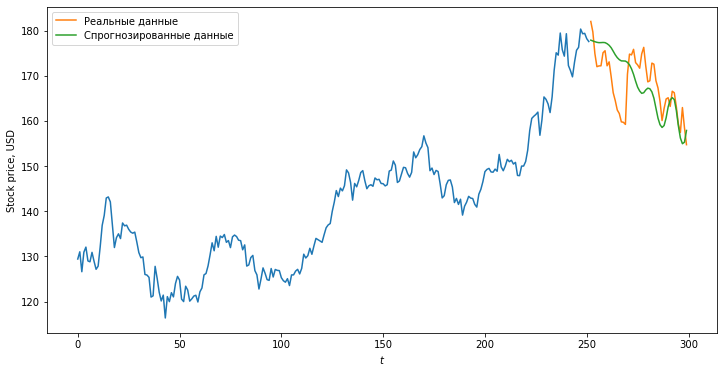

In [13]:
ssa = SSA(110, 4).fit(df)
h = 48

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 1, 1)
plt.plot(ssa.ts)
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(ssa.N, ssa.N+h), ssa.predict(h), label="Спрогнозированные данные")
plt.xlabel("$t$")
plt.ylabel("Stock price, USD")
plt.legend()

Text(0.5, 1.0, '$L = 110$')

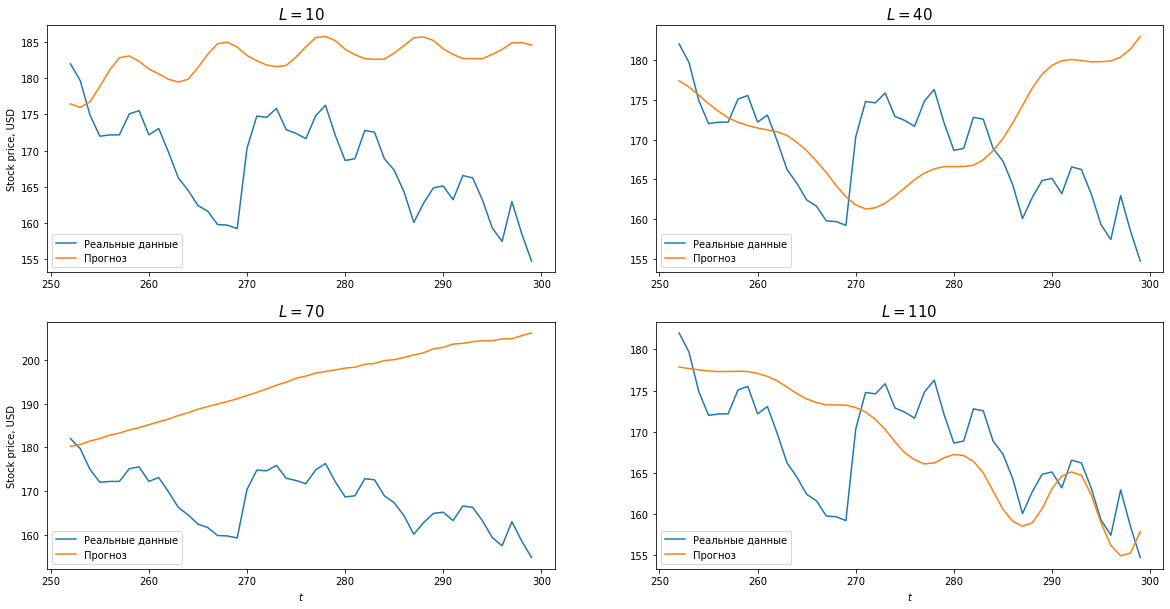

In [14]:
fig = plt.figure(figsize=(20, 10))
axs = fig.subplots(2, 2)
N = 252
h = 48

ax = axs[0, 0]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(10, 4).fit_predict(df, h), label="Прогноз")
ax.set_ylabel("Stock price, USD")
ax.legend(loc=3)
ax.set_title("$L = 10$", fontdict = {'fontsize': 15})

ax = axs[0, 1]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(40, 4).fit_predict(df, h), label="Прогноз")
ax.legend(loc=3)
ax.set_title("$L = 40$", fontdict = {'fontsize': 15})

ax = axs[1, 0]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(70, 4).fit_predict(df, h), label="Прогноз")
ax.set_xlabel("$t$")
ax.set_ylabel("Stock price, USD")
ax.legend(loc=3)
ax.set_title("$L = 70$", fontdict = {'fontsize': 15})

ax = axs[1, 1]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(110, 4).fit_predict(df, h), label="Прогноз")
ax.set_xlabel("$t$")
ax.legend(loc=3)
ax.set_title("$L = 110$", fontdict = {'fontsize': 15})

Text(0.5, 1.0, 'Восстановление по всем компонентам $r = L = 110$')

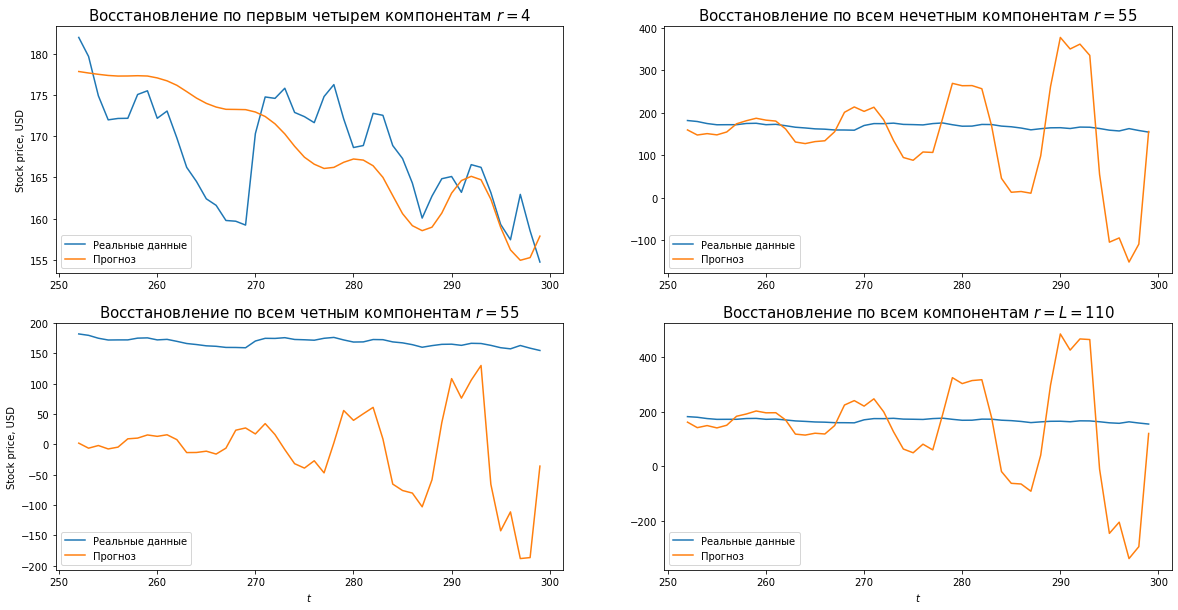

In [15]:
fig = plt.figure(figsize=(20, 10))
axs = fig.subplots(2, 2)
N = 252
h = 48

ax = axs[0, 0]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(110, 4).fit_predict(df, h), label="Прогноз")
ax.set_ylabel("Stock price, USD")
ax.legend(loc=3)
ax.set_title("Восстановление по первым четырем компонентам $r = 4$", fontdict = {'fontsize': 15})

ax = axs[0, 1]
ssa = SSA(110, 55).fit(df)
ssa.reconstructed = np.sum(ssa.R[:, ::2], axis=1)
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), ssa.predict(h), label="Прогноз")
ax.legend(loc=3)
ax.set_title("Восстановление по всем нечетным компонентам $r = 55$", fontdict = {'fontsize': 15})

ax = axs[1, 0]
ssa = SSA(110, 55).fit(df)
ssa.reconstructed = np.sum(ssa.R[:, 1::2], axis=1)
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), ssa.predict(h), label="Прогноз")
ax.set_xlabel("$t$")
ax.set_ylabel("Stock price, USD")
ax.legend(loc=3)
ax.set_title("Восстановление по всем четным компонентам $r = 55$", fontdict = {'fontsize': 15})

ax = axs[1, 1]
ax.plot(real, label="Реальные данные")
ax.plot(np.arange(N, N+h), SSA(110, 110).fit_predict(df, h), label="Прогноз")
ax.set_xlabel("$t$")
ax.legend(loc=3)
ax.set_title("Восстановление по всем компонентам $r = L = 110$", fontdict = {'fontsize': 15})